### **Part 1**
**Tasks**
* explore proper visual stimuli
  * spontaneous state
  * *evoked state: drifting*
* Communication subspaces across different areas
  * *correlation*
  * dimensionality
    * intra_areas
    * inter_areas
* Information flow across subspaces
  * *direction: population correlation as the function of the time delay between areas ($t_2$-$t_1$)*
  * intensity (correlation intensity)
* Hierarchy of information flow  across these subspaces
  * direction
    * *inter_areas cca_delay*
    * intra_areas cca_delay (layer_dependent)
    * feedfward and feedback
  * function validation
* (to do) Relation between different information flow channels
* (to do) State dependent geometrical properties of these channels
* (to do) Dynamical system across areas modeled by multi-region RNN networks

**Problems**
* Correlation_delay data is spiky
  * If 1ms slide, data can not changed a lot
  * Try window step smaller
* Correlation_delay data is too large
* No obvious pattern in Correlation_delay data
  * Delay period longer
  * Shuffle data as refer
  * revert roles of area1 and area2 in Correlation_delay data, delta MI
  * MI_delay, delta_MI_delay, across areas
* Develop intuition for data visualization
  * small try, such PSTH, receptive-field of single unit or across units
  * See more raw data and neuro paper
* Across time & across conditions considering differently

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

In [4]:
# basepath = "E:\Allensdk_data\local\ecephys_cache_dir"
basepath = "/home/jialab/Allensdk_data/local/ecephys_cache_dir/"
manifest_path = os.path.join(basepath, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

sessions = cache.get_session_table()
session_id = 799864342
session = cache.get_session_data(session_id)

### Task1 explore proper visual stimuli

In [3]:
print(session.stimulus_names)

['spontaneous', 'gabors', 'flashes', 'drifting_gratings', 'natural_movie_three', 'natural_movie_one', 'static_gratings', 'natural_scenes', 'drifting_gratings_contrast']


In [5]:
spon_stim_table = session.get_stimulus_table('spontaneous')
print(spon_stim_table['stimulus_condition_id'].value_counts())
spon_stim_table.head()

0    16
Name: stimulus_condition_id, dtype: int64


,start_time,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,
0,29.005689,spontaneous,89.072529,60.066840,0
3646,1001.068151,spontaneous,1290.059739,288.991588,0
3797,1588.559270,spontaneous,1590.310709,1.751439,0
3998,2189.811871,spontaneous,2220.837819,31.025948,0
21999,2821.339779,spontaneous,2851.381559,30.041780,0


In [11]:
drift_stim_table = session.get_stimulus_table('drifting_gratings')
drift_stim_table.head()

,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3798,0.8,135,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1590.310709,2,drifting_gratings,1592.312419,4,2.00171,246
3799,0.8,135,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1593.313231,2,drifting_gratings,1595.314911,15,2.00168,247
3800,0.8,45,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1596.315739,2,drifting_gratings,1598.317439,15,2.00170,248
3801,0.8,0,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1599.318261,2,drifting_gratings,1601.319921,1,2.00166,249
3802,null,null,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",null,1602.320789,2,drifting_gratings,1604.322439,null,2.00165,250


In [6]:
print(drift_stim_table['temporal_frequency'].value_counts())
print(drift_stim_table['orientation'].value_counts())
print(drift_stim_table['stimulus_condition_id'].value_counts())

15.0    120
8.0     120
4.0     120
2.0     120
1.0     120
null     30
Name: temporal_frequency, dtype: int64
315.0    75
225.0    75
180.0    75
45.0     75
90.0     75
270.0    75
135.0    75
0.0      75
null     30
Name: orientation, dtype: int64
250    30
286    15
256    15
263    15
262    15
261    15
260    15
259    15
258    15
257    15
255    15
265    15
254    15
253    15
252    15
251    15
249    15
248    15
247    15
264    15
266    15
285    15
267    15
284    15
283    15
282    15
281    15
280    15
279    15
278    15
277    15
276    15
275    15
274    15
273    15
272    15
271    15
270    15
269    15
268    15
246    15
Name: stimulus_condition_id, dtype: int64


In [6]:
def spike_matrix(area, stim_table, bin=0.1, period=2):
    """spike_matrix _summary_

    _extended_summary_

    Arguments:
        area -- _description_
        stim_table -- _description_

    Keyword Arguments:
        bin -- _description_ (default: {0.1})
        period -- _description_ (default: {2})

    Returns:
        _description_
    """

    area_units = session.units[session.units["ecephys_structure_acronym"] == area]

    time_bins = np.arange(0, period + bin, bin)  

    spike_counts = session.presentationwise_spike_counts(
        stimulus_presentation_ids=stim_table.index.values,  
        bin_edges=time_bins,
        unit_ids=area_units.index.values
    )
    
    response_matrix = spike_counts.values

    return response_matrix

In [8]:
def drift_tuning_curve(area, unit_id, drift_stim_table, bin=0.1):

    temp_freq_list = [1.0, 2.0, 4.0, 8.0, 15.0]
    ori_list = [0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0]

    tunning_curve_matrix = np.empty([len(temp_freq_list), len(ori_list)])

    for i in range(len(temp_freq_list)):
        for j in range(len(ori_list)):
            stim_table = drift_stim_table[(drift_stim_table['temporal_frequency'] == temp_freq_list[i]) 
                                & (drift_stim_table['orientation'] == ori_list[j])]
            response_matrix = spike_matrix(area, stim_table)

            # spikes/s, average spikes across trails and time bins
            response_units = response_matrix.mean(0).mean(0) / bin

            if unit_id < len(response_units):
                tunning_curve_matrix[i, j] = response_units[unit_id]
            else:
                print(f'There is no neuron {unit_id} in {area}')
                return

    print(response_matrix.shape)

    f, ax = plt.subplots(figsize=(12, 10))
    im = ax.pcolormesh(tunning_curve_matrix)

    ax.set_xticks(range(len(ori_list))+np.array([0.5]))
    ax.set_xticklabels(ori_list)
    ax.set_xlabel('orientation')
    ax.set_yticks(range(len(temp_freq_list))+np.array([0.5]))
    ax.set_yticklabels(temp_freq_list)
    ax.set_ylabel('temporal_freqency')
    ax.set_title(f'grating_tuning_curve of neuron {unit_id} in {area}, spikes/s')

    f.colorbar(im)
    plt.show()

    return tunning_curve_matrix

**tunning curve of neurons in VISam**

(15, 20, 29)


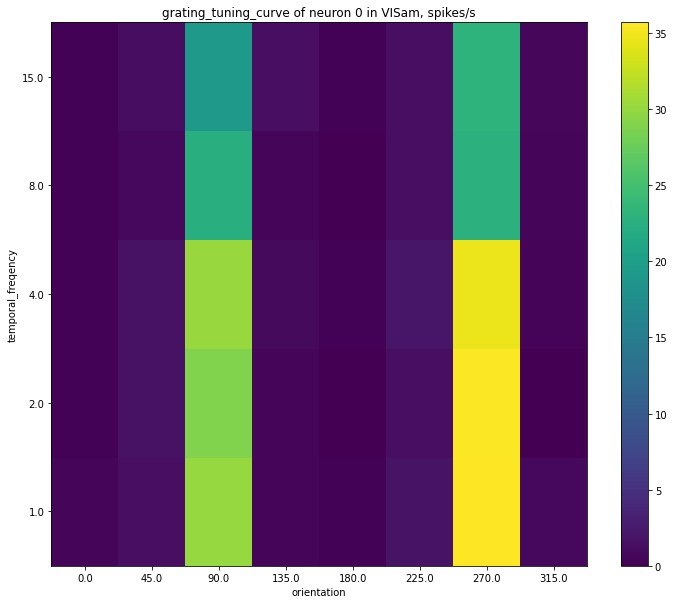

(15, 20, 29)


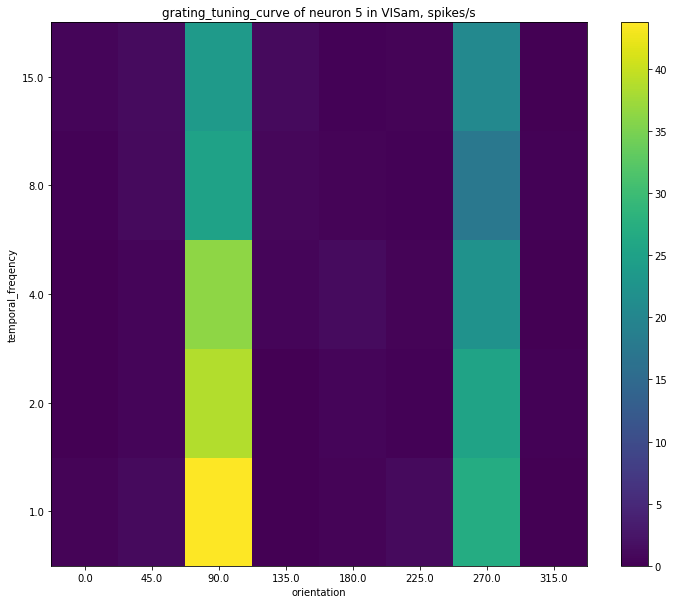

(15, 20, 29)


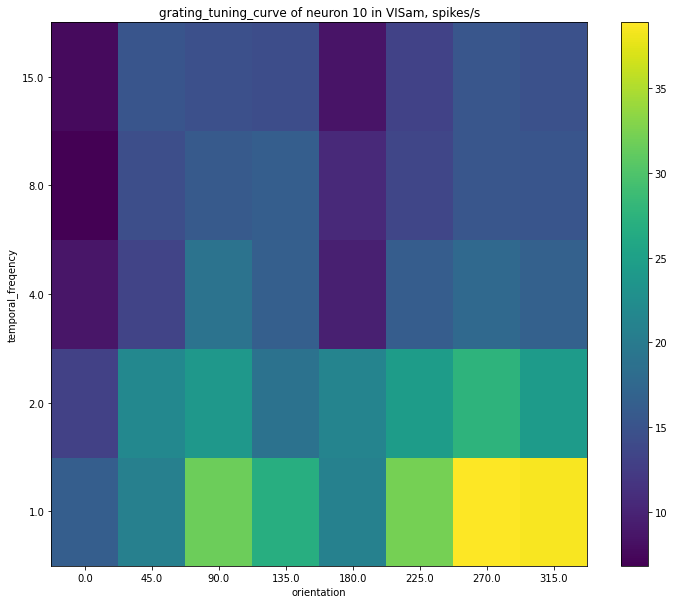

(15, 20, 29)


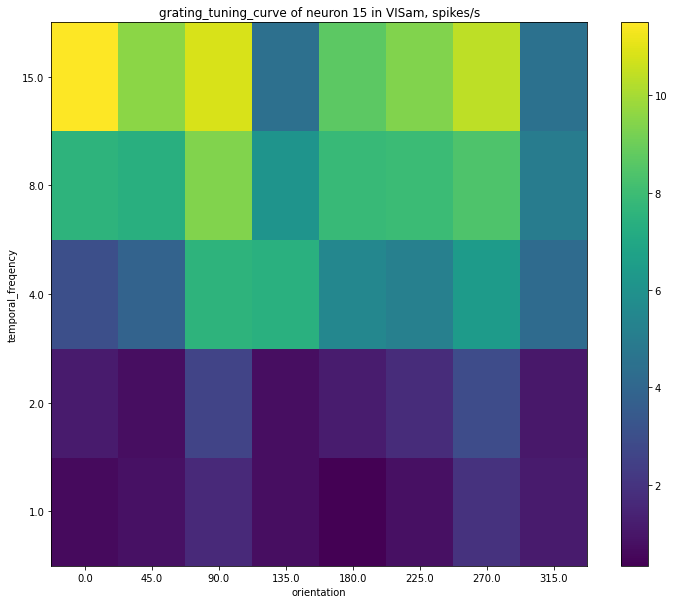

(15, 20, 29)


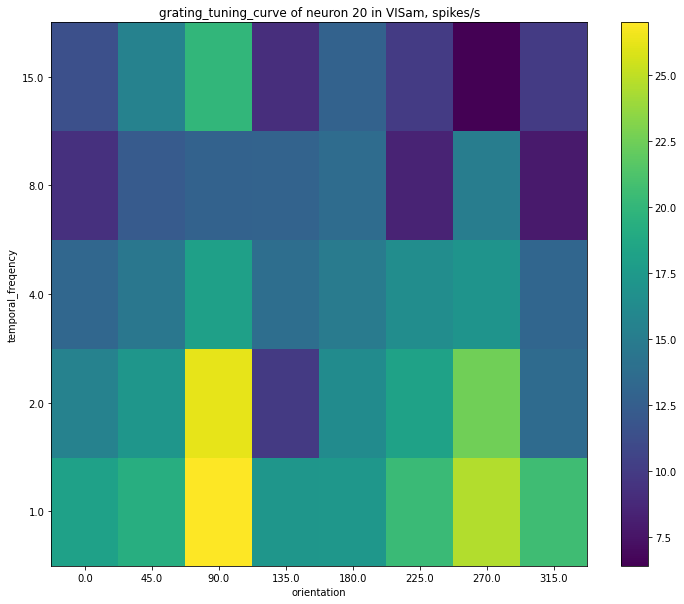

In [9]:
unit_list = [0, 5, 10, 15, 20]

for i in range(len(unit_list)):
    drift_tuning_curve(area='VISam', unit_id=unit_list[i], drift_stim_table=drift_stim_table)

**tunning curve of neurons in CA1**

(15, 20, 109)


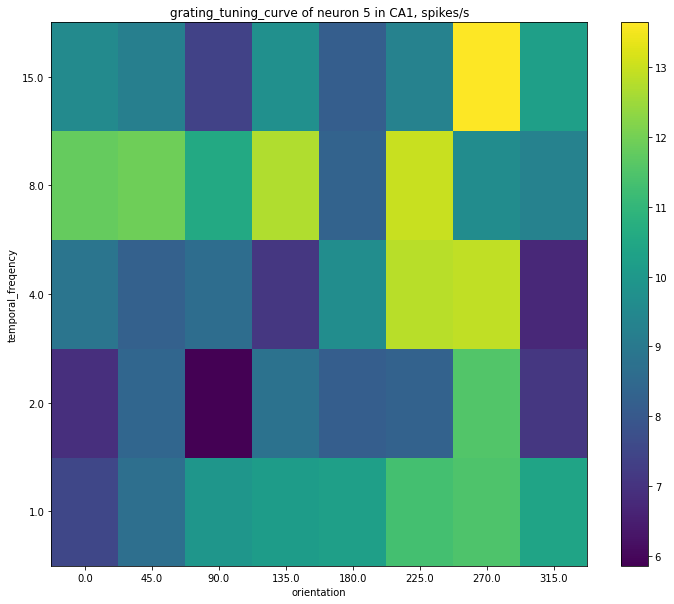

(15, 20, 109)


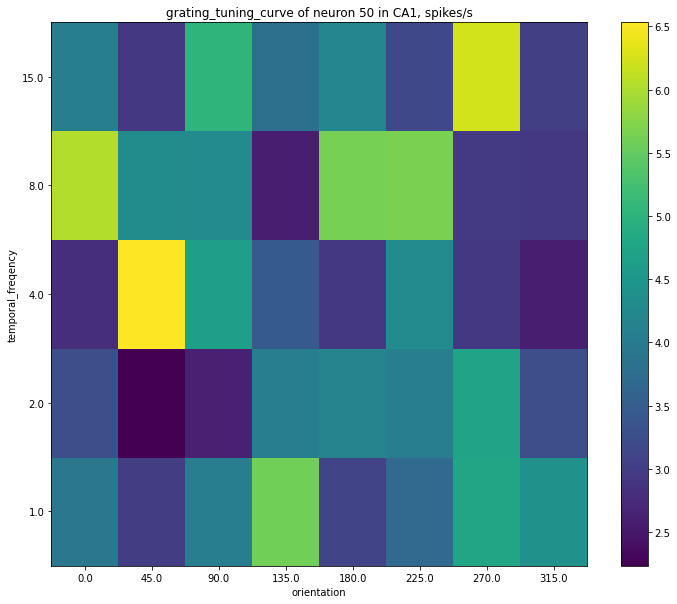

(15, 20, 109)


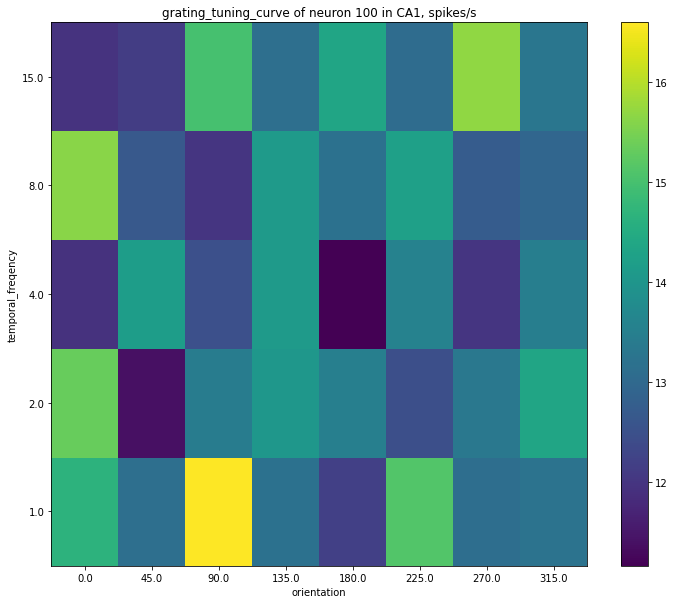

In [10]:
unit_list = [5, 50, 100]

for i in range(len(unit_list)):
    drift_tuning_curve(area='CA1', unit_id=unit_list[i], drift_stim_table=drift_stim_table)

In [11]:
def drift_PSTH(area, unit_id, drift_stim_table, temp_freq=1.0, ori=90.0, bin=0.1, period=2):

    stim_table = drift_stim_table[(drift_stim_table['temporal_frequency'] == temp_freq) 
                        & (drift_stim_table['orientation'] == ori)]
    response_matrix = spike_matrix(area, stim_table, bin=bin)

    # spikes/s, average spikes across trails and time bins, shape=bins*neurons
    response_matrix = response_matrix.mean(0) / bin

    if unit_id < response_matrix.shape[1]:
        unit_psth = response_matrix[:, unit_id]
    else:
        print(f'There is no neuron {unit_id} in {area}')
        return

    print(response_matrix.shape)

    time_bins = np.linspace(0, period, 9)
    tick_bins = time_bins/bin
    label_bins = time_bins

    plt.figure()
    plt.plot(unit_psth)
    plt.title(f'PSTH of neuron {unit_id} in {area}')
    plt.xlabel('time, s')
    plt.xticks(ticks=tick_bins, labels=label_bins)
    plt.ylabel('firing rates, spikes/s')
    plt.show()

    return unit_psth

**PSTH of neurons in VISam**

(20, 29)


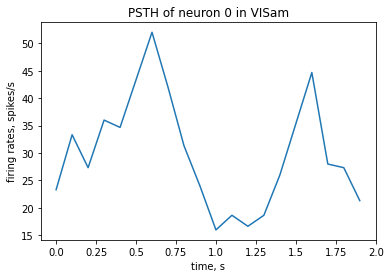

(20, 29)


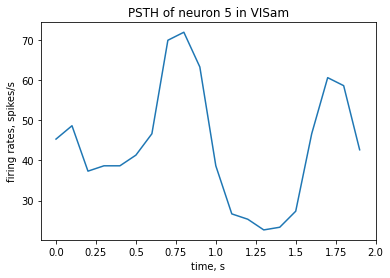

(20, 29)


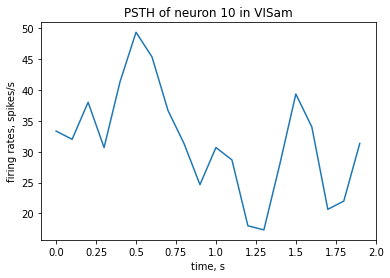

(20, 29)


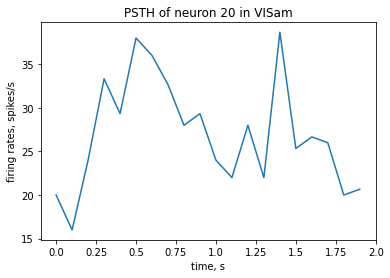

In [12]:
unit_list = [0, 5, 10, 20]

for i in range(len(unit_list)):
    drift_PSTH(area='VISam', unit_id=unit_list[i], drift_stim_table=drift_stim_table)

**PSTH of different bins in VISam neuron0**

In [13]:
def drift_PSTH_bins(area, unit_id, drift_stim_table, temp_freq=1.0, ori=90.0, bin=0.1, period=2):

    stim_table = drift_stim_table[(drift_stim_table['temporal_frequency'] == temp_freq) 
                        & (drift_stim_table['orientation'] == ori)]
    response_matrix = spike_matrix(area, stim_table, bin=bin)

    # spikes/time_bin, average spikes across trails and time bins, shape=bins*neurons
    response_matrix = response_matrix.mean(0)

    if unit_id < response_matrix.shape[1]:
        unit_psth = response_matrix[:, unit_id]
    else:
        print(f'There is no neuron {unit_id} in {area}')
        return

    print(response_matrix.shape)

    time_bins = np.linspace(0, period, 9)
    tick_bins = time_bins/bin
    label_bins = time_bins

    plt.figure()
    plt.plot(unit_psth)
    plt.title(f'PSTH of neuron {unit_id} in {area}, bin={bin}')
    plt.xlabel('time, s')
    plt.xticks(ticks=tick_bins, labels=label_bins)
    plt.ylabel('firing rates, spikes/time_bin')
    plt.show()

    return unit_psth

(20, 29)


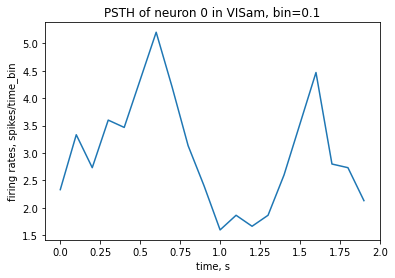

(40, 29)


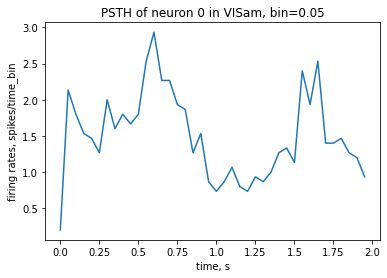

(200, 29)


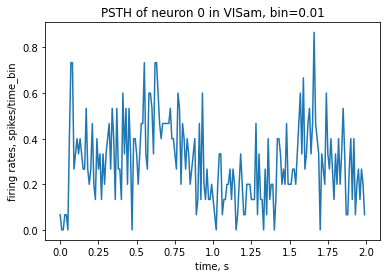

(400, 29)


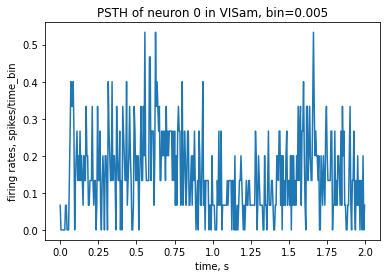

(2000, 29)


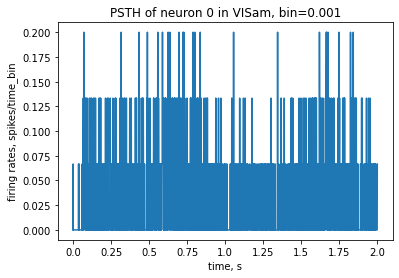

In [14]:
bin_list = [0.1, 0.05, 0.01, 0.005, 0.001]

for i in range(len(bin_list)):
    drift_PSTH_bins(area='VISam', unit_id=0, drift_stim_table=drift_stim_table, bin=bin_list[i])

### Task2 CCA correlation across areas

In [7]:
def corr_area_pairs(X_a, X_b, n_components = 3):
    """corr_area_pairs _summary_

    _extended_summary_

    Arguments:
        X_a -- _description_
        X_b -- _description_
    """

    cca = CCA(n_components, max_iter=1000)
    cca.fit(X_a, X_b)
    z_a, z_b = cca.transform(X_a, X_b) 

    # get weight after cca
    w_a = cca.x_rotations_
    w_b = cca.y_rotations_
    
    # get correlation of hidden z
    corr_z = np.empty(n_components)
    for i in range(n_components):
        corr_z[i] = np.corrcoef(z_a[:, i], z_b[:, i])[0, 1]

    return corr_z, (w_a, w_b), (z_a, z_b)

[0.001 0.011 0.021 0.031 0.041 0.051 0.061 0.071 0.081 0.091 0.101 0.111
 0.121 0.131 0.141 0.151 0.161 0.171 0.181 0.191]


Text(0, 0.5, 'corrlelation')

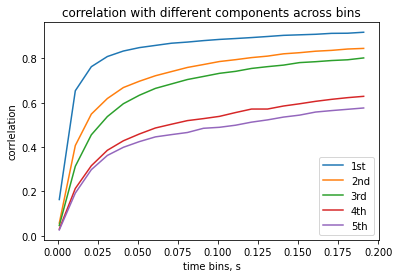

In [16]:
# plot correlation between CA1 and CA3 contrast to different bins

components = 5
bins = (np.arange(0, 200, 10) + 1) / 1000
print(bins)
corr_matrix = np.empty([len(bins), components])

for i in np.arange(len(bins)):
    response_matrix = spike_matrix(area='CA1', stim_table=drift_stim_table, bin=bins[i])
    res_mat_1 = response_matrix.reshape(response_matrix.shape[0]*response_matrix.shape[1],
                                    response_matrix.shape[2])
    response_matrix = spike_matrix(area='CA3', stim_table=drift_stim_table, bin=bins[i])
    res_mat_2 = response_matrix.reshape(response_matrix.shape[0]*response_matrix.shape[1],
                                    response_matrix.shape[2])
    corr, w, z = corr_area_pairs(res_mat_1, res_mat_2, n_components=components)
    corr_matrix[i] = corr

plt.figure()
plt.plot(bins, corr_matrix)
plt.title('correlation with different components across bins')
plt.xlabel('time bins, s')
plt.legend(labels=['1st', '2nd', '3rd', '4th', '5th'])
plt.ylabel('corrlelation')

[1, 5, 10, 30, 50, 100, 200, 300, 500]


Text(0, 0.5, '1st corrlelation')

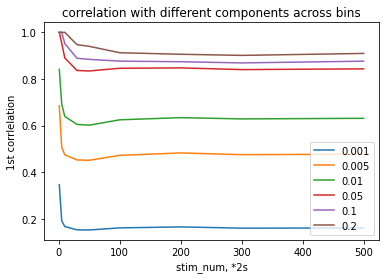

In [17]:
# plot correlation between CA1 and CA3 contrast to different time_periods

stim_num = [1, 5, 10, 30, 50, 100, 200, 300, 500] # total stim: 5*8*15+30=630
print(stim_num)
bins = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
corr_matrix = np.empty([len(bins), len(stim_num)])

for i in range(len(bins)):
    for j in range(len(stim_num)):
        response_matrix = spike_matrix(area='CA1', stim_table=drift_stim_table, bin=bins[i])
        response_matrix = response_matrix[:stim_num[j], :, :]
        res_mat_1 = response_matrix.reshape(response_matrix.shape[0]*response_matrix.shape[1],
                                        response_matrix.shape[2])
        response_matrix = spike_matrix(area='CA3', stim_table=drift_stim_table, bin=bins[i])
        response_matrix = response_matrix[:stim_num[j], :, :]
        res_mat_2 = response_matrix.reshape(response_matrix.shape[0]*response_matrix.shape[1],
                                        response_matrix.shape[2])
        corr, w, z = corr_area_pairs(res_mat_1, res_mat_2)
        corr_matrix[i, j] = corr[0]

plt.figure()
plt.plot(stim_num, corr_matrix.T)
plt.title('correlation with different components across bins')
plt.xlabel('stim_num, *2s')
plt.legend(labels=bins, loc='lower right')
plt.ylabel('1st corrlelation')

In [9]:
areas = session.structure_acronyms
print(len(areas))
print(areas)

# delete nan in areas
while np.nan in areas:
    areas.remove(np.nan)

# delete area with no units
for area in areas:
    units = session.units[session.units["ecephys_structure_acronym"] == area]
    if units.shape[0] == 0:
        areas.remove(area)
print(len(areas))
print(areas)

18
['VISam', nan, 'COAa', 'CA1', 'LP', 'DG', 'VISmma', 'VISp', 'ProS', 'SUB', 'CA3', 'CA2', 'VISl', 'VISal', 'LGd', 'VISrl', 'APN', 'POL']
16
['VISam', 'CA1', 'LP', 'DG', 'VISmma', 'VISp', 'ProS', 'SUB', 'CA3', 'CA2', 'VISl', 'VISal', 'LGd', 'VISrl', 'APN', 'POL']


In [8]:
def CCA_across_areas(stim_table, areas, component=0):
    
    areas_corr_matrix = np.empty([len(areas), len(areas)])

    for i in range(len(areas)):
        for j in range(len(areas)):
            response_matrix = spike_matrix(area = areas[i], stim_table=stim_table)
            res_mat_i = response_matrix.reshape(response_matrix.shape[0]*response_matrix.shape[1],
                                                response_matrix.shape[2])
            response_matrix = spike_matrix(area = areas[j], stim_table=stim_table)
            res_mat_j = response_matrix.reshape(response_matrix.shape[0]*response_matrix.shape[1],
                                                response_matrix.shape[2])

            corr_ij, w, z = corr_area_pairs(res_mat_i, res_mat_j)
            areas_corr_matrix[i, j] = corr_ij[component]

    return areas_corr_matrix

16
['VISmma', 'VISam', 'VISl', 'VISal', 'VISrl', 'VISp', 'LP', 'LGd', 'DG', 'ProS', 'CA1', 'CA2', 'CA3', 'SUB', 'APN', 'POL']


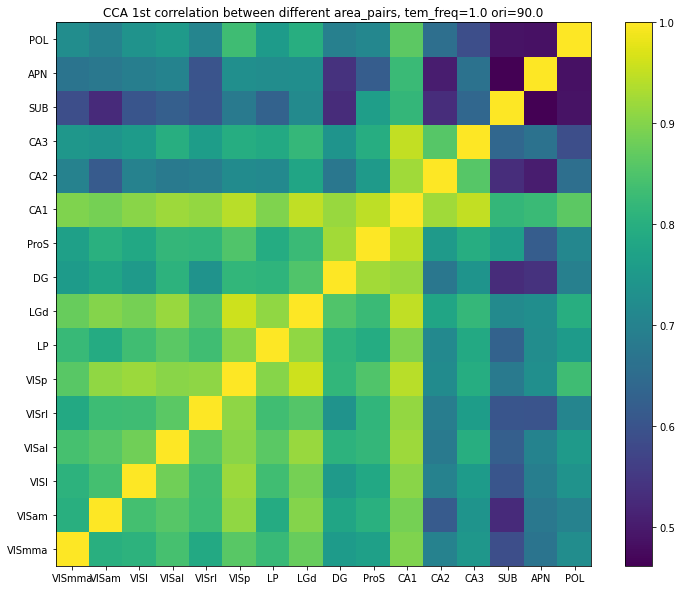

In [20]:
# sorted after CCA for blocking
areas_sorted = ['VISmma', 'VISam', 'VISl', 'VISal', 'VISrl', 'VISp', 'LP', 'LGd', 'DG', 'ProS', 'CA1', 'CA2', 'CA3', 'SUB', 'APN', 'POL']
print(len(areas_sorted))
print(areas_sorted)

stim_table_trial = drift_stim_table[(drift_stim_table['temporal_frequency'] == 1.0) 
                    & (drift_stim_table['orientation'] == 90.0)]

areas_corr_matrix = CCA_across_areas(stim_table=stim_table_trial, areas=areas_sorted)

f, ax = plt.subplots(figsize=(12, 10))
im = ax.pcolormesh(areas_corr_matrix)

ax.set_xticks(range(len(areas_sorted))+np.array([0.5]))
ax.set_xticklabels(areas_sorted)
ax.set_yticks(range(len(areas_sorted))+np.array([0.5]))
ax.set_yticklabels(areas_sorted)
ax.set_title('CCA 1st correlation between different area_pairs, tem_freq=1.0 ori=90.0')

f.colorbar(im)

16
['VISmma', 'VISam', 'VISl', 'VISal', 'VISrl', 'VISp', 'LP', 'LGd', 'DG', 'ProS', 'CA1', 'CA2', 'CA3', 'SUB', 'APN', 'POL']


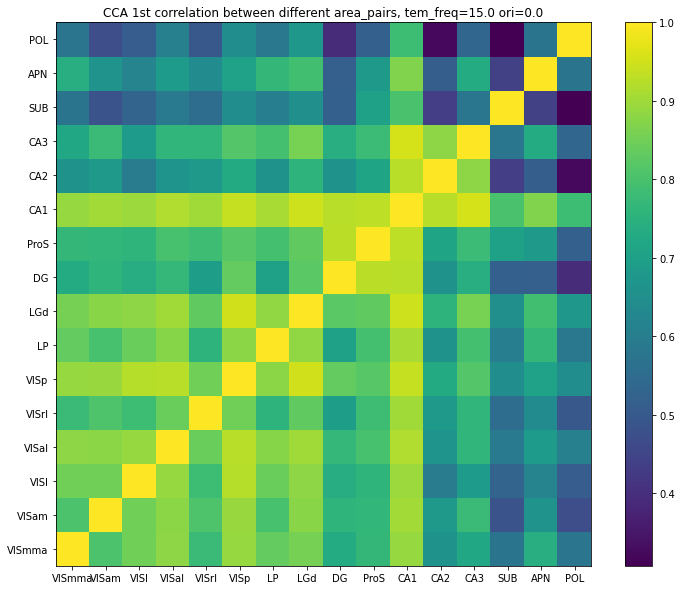

In [21]:
# sorted after CCA for blocking
areas_sorted = ['VISmma', 'VISam', 'VISl', 'VISal', 'VISrl', 'VISp', 'LP', 'LGd', 'DG', 'ProS', 'CA1', 'CA2', 'CA3', 'SUB', 'APN', 'POL']
print(len(areas_sorted))
print(areas_sorted)

stim_table_trial = drift_stim_table[(drift_stim_table['temporal_frequency'] == 15.0) 
                    & (drift_stim_table['orientation'] == 0.0)]

areas_corr_matrix = CCA_across_areas(stim_table=stim_table_trial, areas=areas_sorted)

f, ax = plt.subplots(figsize=(12, 10))
im = ax.pcolormesh(areas_corr_matrix)

ax.set_xticks(range(len(areas_sorted))+np.array([0.5]))
ax.set_xticklabels(areas_sorted)
ax.set_yticks(range(len(areas_sorted))+np.array([0.5]))
ax.set_yticklabels(areas_sorted)
ax.set_title('CCA 1st correlation between different area_pairs, tem_freq=15.0 ori=0.0')

f.colorbar(im)

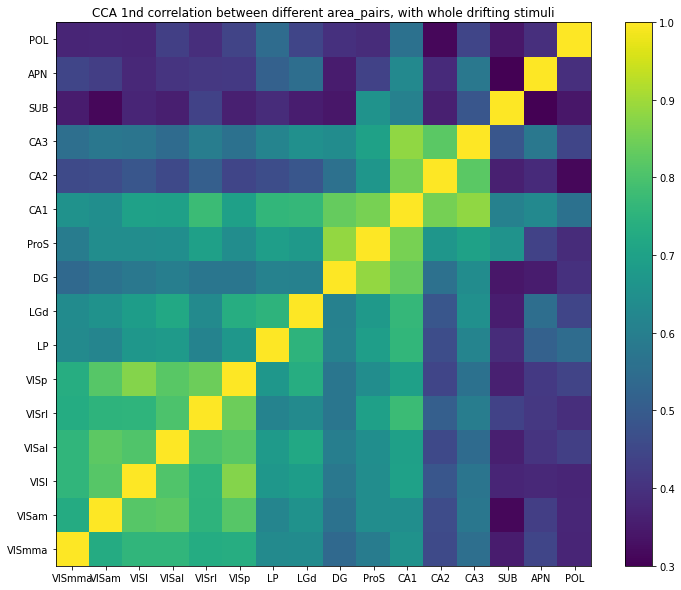

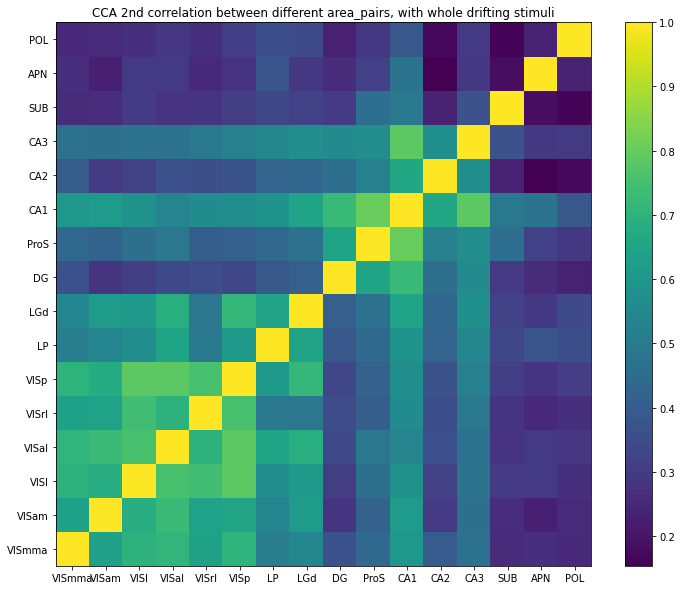

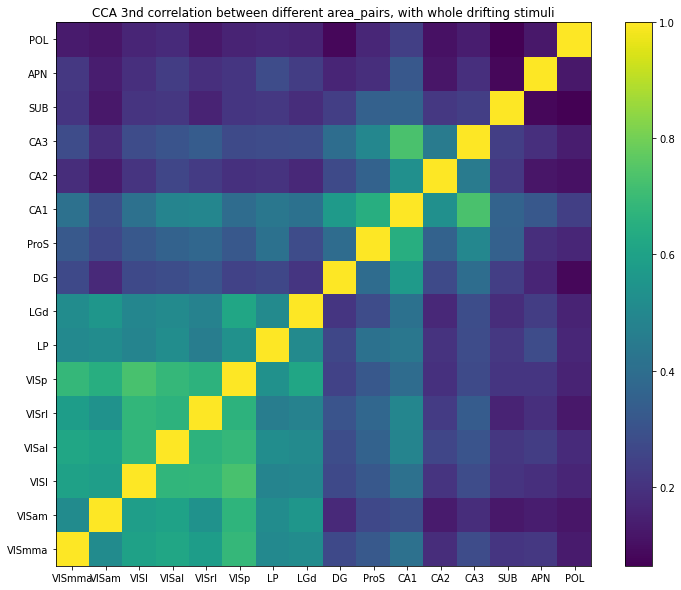

In [22]:
# sorted after CCA for blocking
areas_sorted = ['VISmma', 'VISam', 'VISl', 'VISal', 'VISrl', 'VISp', 'LP', 'LGd', 'DG', 'ProS', 'CA1', 'CA2', 'CA3', 'SUB', 'APN', 'POL']

for i in range(3):
    areas_corr_matrix = CCA_across_areas(stim_table=drift_stim_table, areas=areas_sorted, component=i)

    f, ax = plt.subplots(figsize=(12, 10))
    im = ax.pcolormesh(areas_corr_matrix)

    ax.set_xticks(range(len(areas_sorted))+np.array([0.5]))
    ax.set_xticklabels(areas_sorted)
    ax.set_yticks(range(len(areas_sorted))+np.array([0.5]))
    ax.set_yticklabels(areas_sorted)
    ax.set_title(f'CCA {i+1}nd correlation between different area_pairs, with whole drifting stimuli')

    f.colorbar(im)

### Task3 CCA correlation across areas with time_delay

* combine windows of trials together, not combine trials together and then select window 

In [23]:
# for debug
spikes_raster = np.random.randint(0, 10, (2, 5, 3))
# print(spikes_raster)
# print(spikes_raster.shape)
bin_len = 2
trials_num, trial_len, units_num = spikes_raster.shape  # 2, 5, 3
binned_trial_len = int(trial_len / bin_len)  # 2

if (trial_len % bin_len) != 0:
    spikes_raster = np.delete(spikes_raster, range(bin_len*binned_trial_len, trial_len), 1)

spikes_raster = spikes_raster.transpose([0, 2, 1])  # 2, 3, 4
spikes_raster = spikes_raster.reshape([trials_num, units_num*binned_trial_len, bin_len])
spikes = spikes_raster.sum(2)
spikes = spikes.reshape([trials_num, units_num, binned_trial_len])
spikes = spikes.transpose([0, 2, 1])
print(spikes)
print(spikes.shape)

spikes = spikes.reshape([trials_num*binned_trial_len, units_num])
print(spikes)
print(spikes.shape)

[[[ 3  3 11]
  [13 10  8]]

 [[ 5 14 13]
  [12 12 12]]]
(2, 2, 3)
[[ 3  3 11]
 [13 10  8]
 [ 5 14 13]
 [12 12 12]]
(4, 3)


In [13]:
def spike_counts_bins(spikes_raster, bin_len):

    if bin_len == 1:
        return
    
    trials_num, trial_len, units_num = spikes_raster.shape
    binned_trial_len = int(trial_len / bin_len)

    if (trial_len % bin_len) != 0:
        spikes_raster = np.delete(spikes_raster, range(bin_len*binned_trial_len, trial_len), 1)

    spikes_raster = spikes_raster.transpose([0, 2, 1])
    spikes_raster = spikes_raster.reshape([trials_num, units_num*binned_trial_len, bin_len])
    spikes = spikes_raster.sum(2)
    spikes = spikes.reshape([trials_num, units_num, binned_trial_len])
    spikes = spikes.transpose([0, 2, 1])

    return spikes

(45, 200)


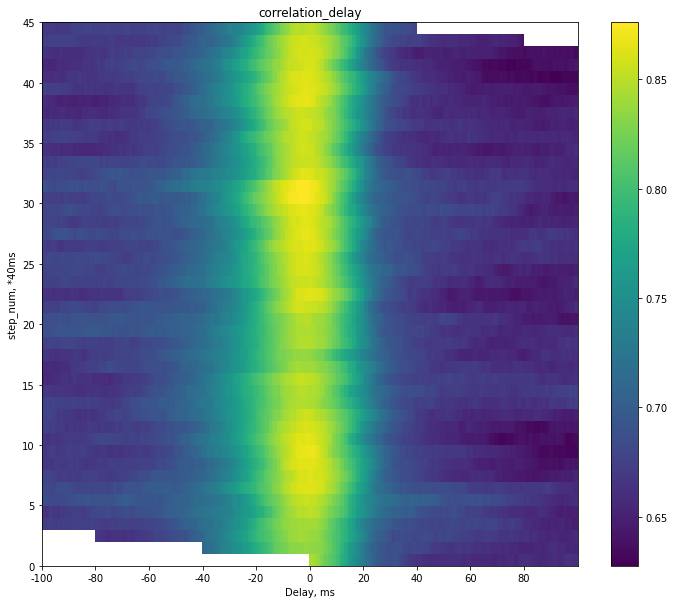

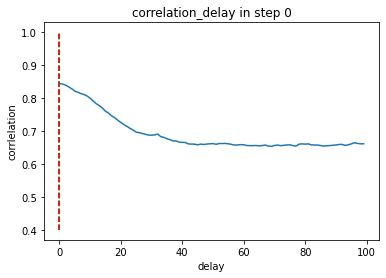

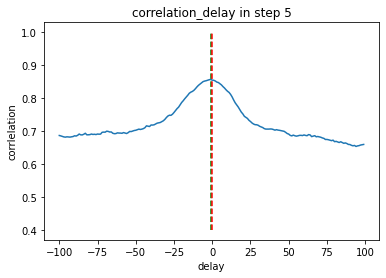

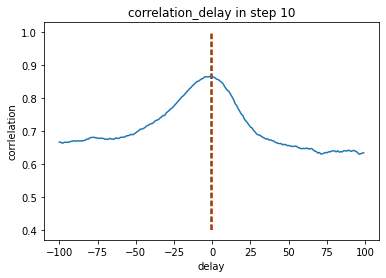

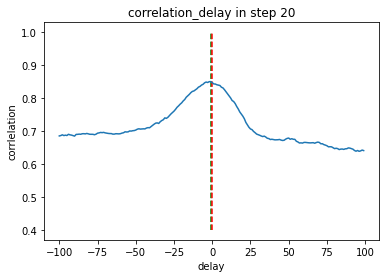

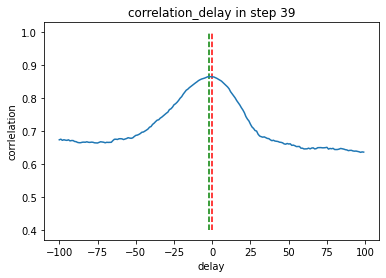

In [17]:
# correlation by delay when time bin = 1ms, with window 200ms, window slide advanced 40ms

raster_bin = 1  # bin time, 1ms

spike_raster_1 = spike_matrix(area='CA1', stim_table=drift_stim_table, bin=raster_bin/1000)
spike_raster_2 = spike_matrix(area='CA3', stim_table=drift_stim_table, bin=raster_bin/1000)

trial_len = 2000 # stimulus time, 2000ms
window_len = 200 # ms
step_len = 40 # ms
bin_len = 50 # ms

max_delay = 100 # ms

step_points = np.arange(0, trial_len-window_len, step_len)

corr_matrix_delay = np.zeros((len(step_points), 2*max_delay))

for step_id, step in enumerate(step_points):
    t_1 = step
    window_1 = np.arange(t_1, t_1+window_len)
    spike_counts_1 = spike_counts_bins(spike_raster_1[:, window_1, :], bin_len)
    spike_counts_1 = spike_counts_1.reshape([spike_counts_1.shape[0]*spike_counts_1.shape[1],
                                            spike_counts_1.shape[2]])

    slide_points = range(max(t_1-max_delay, 0), min(t_1+max_delay, trial_len-window_len))

    for slide_id, slide in enumerate(slide_points):
        t_2 = slide
        window_2 = np.arange(t_2, t_2+window_len)
        spike_counts_2 = spike_counts_bins(spike_raster_2[:, window_2, :], bin_len)
        spike_counts_2 = spike_counts_2.reshape([spike_counts_2.shape[0]*spike_counts_2.shape[1],
                                            spike_counts_2.shape[2]])

        corr, w, z = corr_area_pairs(spike_counts_1, spike_counts_2)
        corr_matrix_delay[step_id, t_2-t_1+max_delay] = corr[0]

print(corr_matrix_delay.shape)
# mask no correlation value
corr_matrix_delay = np.ma.masked_where(corr_matrix_delay == 0, corr_matrix_delay)

f, ax = plt.subplots(figsize=(12, 10))
im = ax.pcolormesh(corr_matrix_delay)

ax.set_xticks(range(0, corr_matrix_delay.shape[1], 20))
ax.set_xticklabels(range(0, corr_matrix_delay.shape[1], 20)-np.array([max_delay]))
# ax.set_yticks(range(len(areas))+np.array([0.5]))
# ax.set_yticklabels(areas)
ax.set_xlabel('Delay, ms')
ax.set_ylabel('step_num, *40ms')
ax.set_title(f'correlation_delay')

f.colorbar(im)

plt.show

step_list = [0, 5, 10, 20, 39]

for step in step_list:
    plt.figure()
    plt.plot(range(-max_delay, max_delay), corr_matrix_delay[step, :])
    plt.vlines(np.argmax(corr_matrix_delay[step, :])-max_delay, 0.4, 1, colors = "g", linestyles = "dashed")
    plt.vlines(0, 0.4, 1, colors = "r", linestyles = "dashed")
    plt.title(f'correlation_delay in step {step}')
    plt.xlabel('delay')
    plt.ylabel('corrlelation')
    plt.show

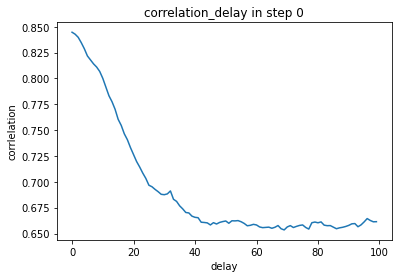

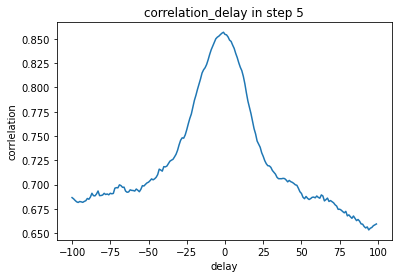

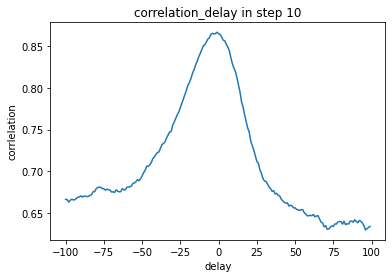

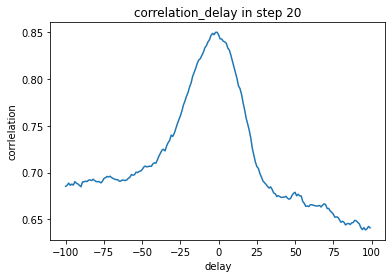

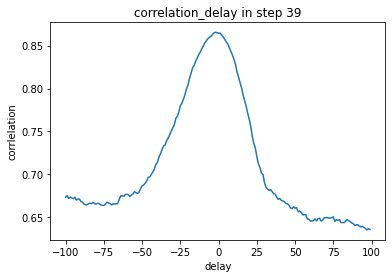

In [18]:
step_list = [0, 5, 10, 20, 39]

for step in step_list:
    plt.figure()
    plt.plot(range(-max_delay, max_delay), corr_matrix_delay[step, :])
    # plt.vlines(np.argmax(corr_matrix_delay[step, :])-max_delay, 0.4, 1, colors = "g", linestyles = "dashed")
    # plt.vlines(0, 0.4, 1, colors = "r", linestyles = "dashed")
    plt.title(f'correlation_delay in step {step}')
    plt.xlabel('delay')
    plt.ylabel('corrlelation')
    plt.show

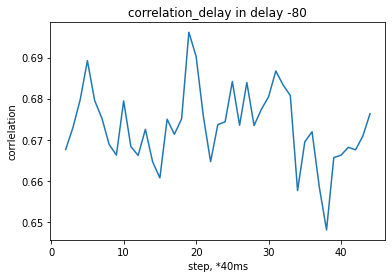

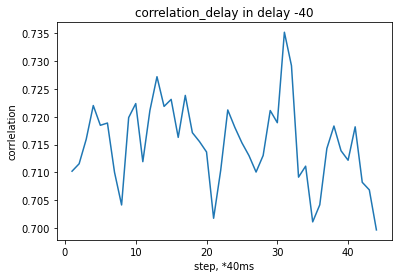

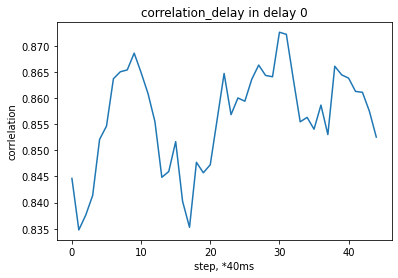

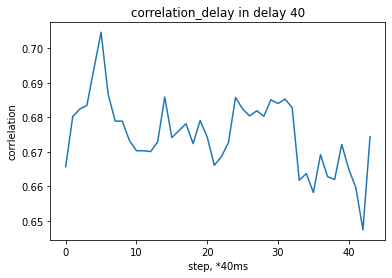

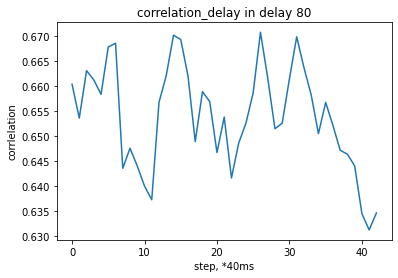

In [19]:
delay_list = [-80, -40, 0, 40, 80]

for delay in delay_list:
    plt.figure()
    plt.plot(range(len(step_points)), corr_matrix_delay[:, delay+max_delay])
    plt.title(f'correlation_delay in delay {delay}')
    plt.xlabel('step, *40ms')
    plt.ylabel('corrlelation')
    # plt.ylim(0.6, 0.9)
    plt.show

In [20]:
def cca_delay(area_1, area_2, trial_len=2000, window_len=200, step_len=40, bin_len=50, max_delay=100):

    # correlation by delay when time bin = 1ms, with window 200ms, window slide advanced 40ms

    raster_bin = 1  # bin time, 1ms

    spike_raster_1 = spike_matrix(area=area_1, stim_table=drift_stim_table, bin=raster_bin/1000)
    spike_raster_2 = spike_matrix(area=area_2, stim_table=drift_stim_table, bin=raster_bin/1000)

    step_points = np.arange(0, trial_len-window_len, step_len)

    corr_matrix_delay = np.zeros((len(step_points), 2*max_delay))

    for step_id, step in enumerate(step_points):
        t_1 = step
        window_1 = np.arange(t_1, t_1+window_len)
        spike_counts_1 = spike_counts_bins(spike_raster_1[:, window_1, :], bin_len)
        spike_counts_1 = spike_counts_1.reshape([spike_counts_1.shape[0]*spike_counts_1.shape[1],
                                                spike_counts_1.shape[2]])

        slide_points = range(max(t_1-max_delay, 0), min(t_1+max_delay, trial_len-window_len))

        for slide_id, slide in enumerate(slide_points):
            t_2 = slide
            window_2 = np.arange(t_2, t_2+window_len)
            spike_counts_2 = spike_counts_bins(spike_raster_2[:, window_2, :], bin_len)
            spike_counts_2 = spike_counts_2.reshape([spike_counts_2.shape[0]*spike_counts_2.shape[1],
                                                spike_counts_2.shape[2]])

            corr, w, z = corr_area_pairs(spike_counts_1, spike_counts_2)
            corr_matrix_delay[step_id, t_2-t_1+max_delay] = corr[0]

    print(corr_matrix_delay.shape)
    # mask no correlation value
    corr_matrix_delay = np.ma.masked_where(corr_matrix_delay == 0, corr_matrix_delay)

    f, ax = plt.subplots(figsize=(12, 10))
    im = ax.pcolormesh(corr_matrix_delay)

    ax.set_xticks(range(0, corr_matrix_delay.shape[1], 20))
    ax.set_xticklabels(range(0, corr_matrix_delay.shape[1], 20)-np.array([max_delay]))
    # ax.set_yticks(range(len(areas))+np.array([0.5]))
    # ax.set_yticklabels(areas)
    ax.set_xlabel('Delay, ms')
    ax.set_ylabel('step_num, *40ms')
    ax.set_title(f'correlation_delay between {area_1} & {area_2}')

    f.colorbar(im)

    plt.show

    step_list = [0, 5, 10, 20, 39]

    for step in step_list:
        plt.figure()
        plt.plot(range(-max_delay, max_delay), corr_matrix_delay[step, :])
        # plt.vlines(np.argmax(corr_matrix_delay[step, :])-max_delay, 0.4, 1, colors = "g", linestyles = "dashed")
        # plt.vlines(0, 0.4, 1, colors = "r", linestyles = "dashed")
        plt.title(f'correlation_delay in step {step} between {area_1} & {area_2}')
        plt.xlabel('delay')
        plt.ylabel('corrlelation')
        plt.show
    
    delay_list = [-80, -40, 0, 40, 80]

    for delay in delay_list:
        plt.figure()
        plt.plot(range(len(step_points)), corr_matrix_delay[:, delay+max_delay])
        plt.title(f'correlation_delay in delay {delay} between {area_1} & {area_2}')
        plt.xlabel('step, *40ms')
        plt.ylabel('corrlelation')
        # plt.ylim(0.6, 0.9)
        plt.show

    return corr_matrix_delay

In [ ]:
# plot across every two areas with step 5, 200ms
area_1 = 'VISmma'
area_2 = 'VISam'
corr_matrix_delay = cca_delay(area_1, area_2)

16
['VISmma', 'VISam', 'VISl', 'VISal', 'VISrl', 'VISp', 'LP', 'LGd', 'DG', 'ProS', 'CA1', 'CA2', 'CA3', 'SUB', 'APN', 'POL']
(45, 200)
(45, 200)


/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(45, 200)
(45, 200)


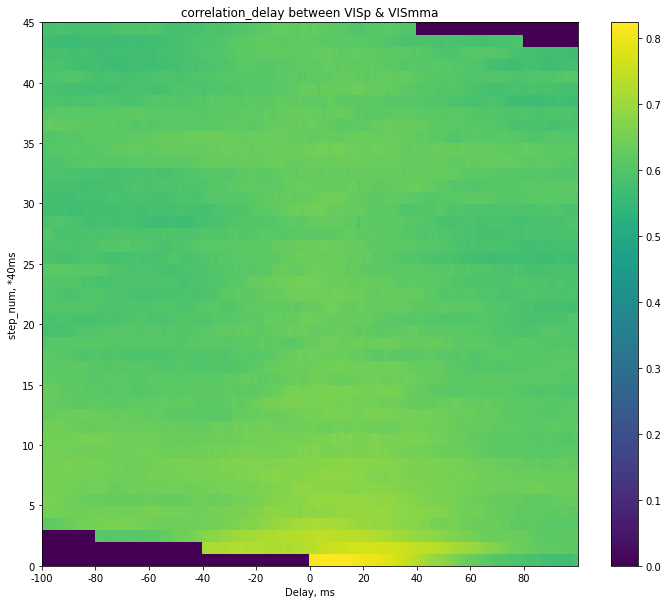

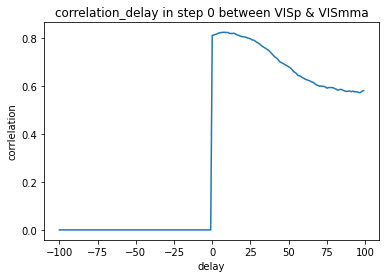

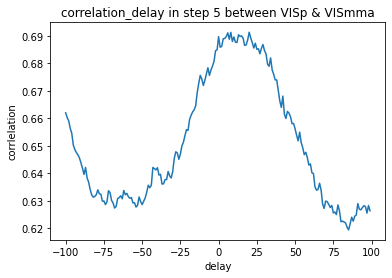

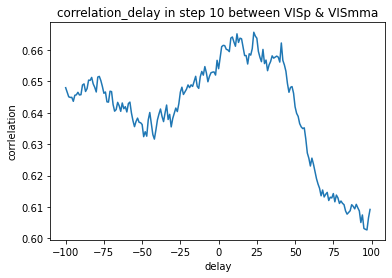

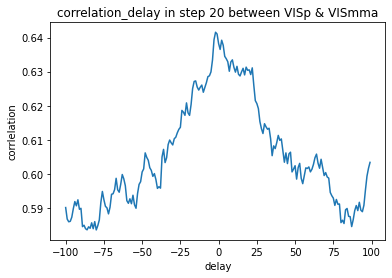

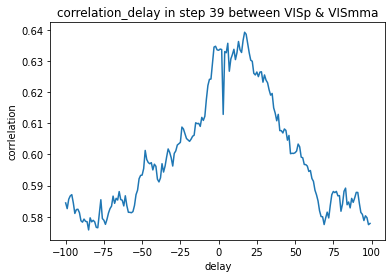

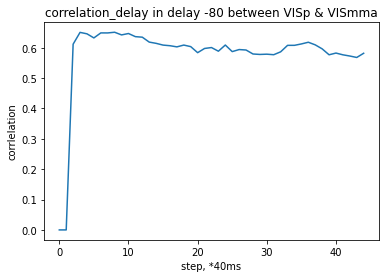

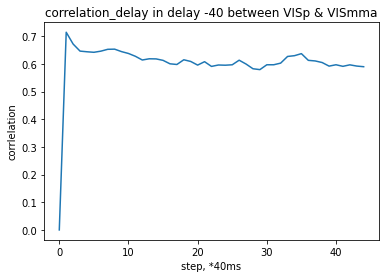

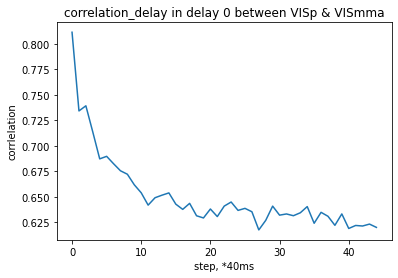

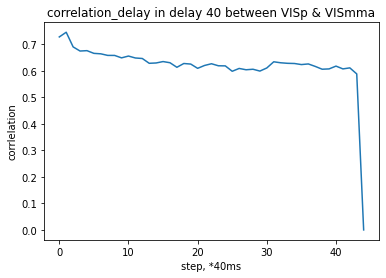

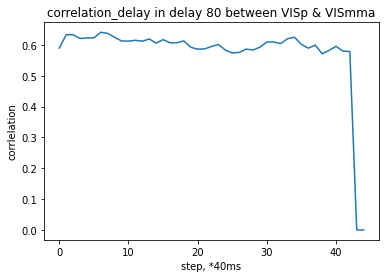

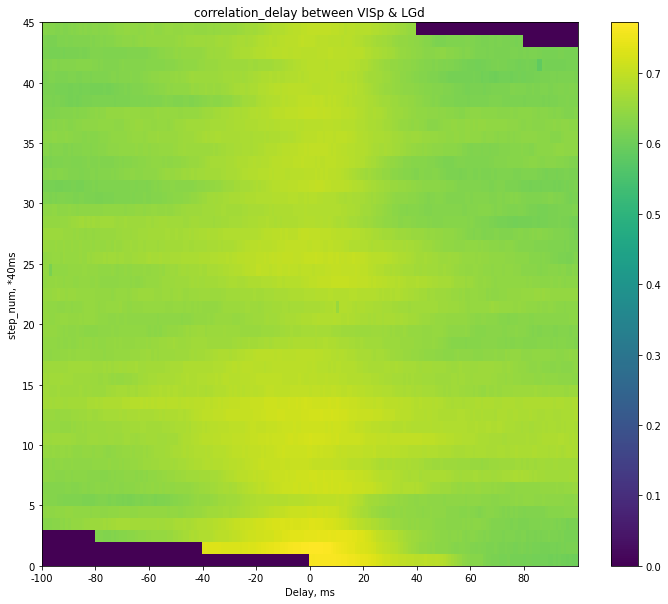

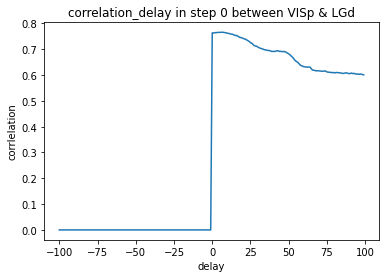

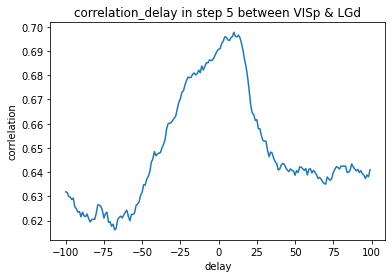

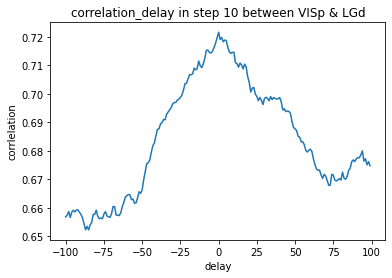

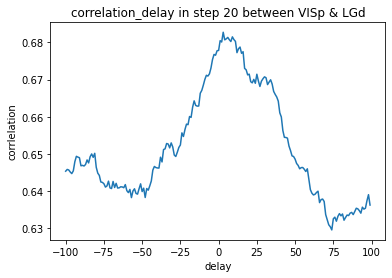

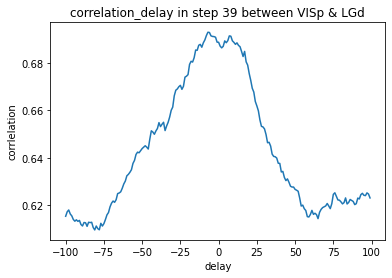

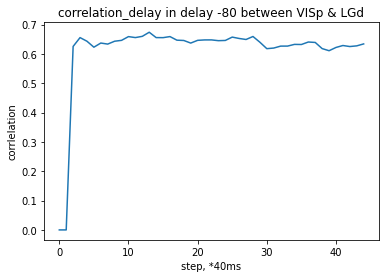

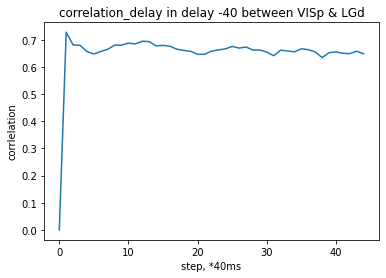

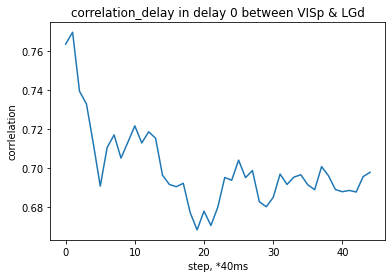

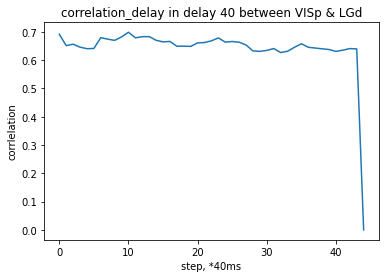

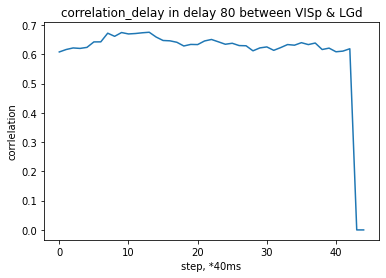

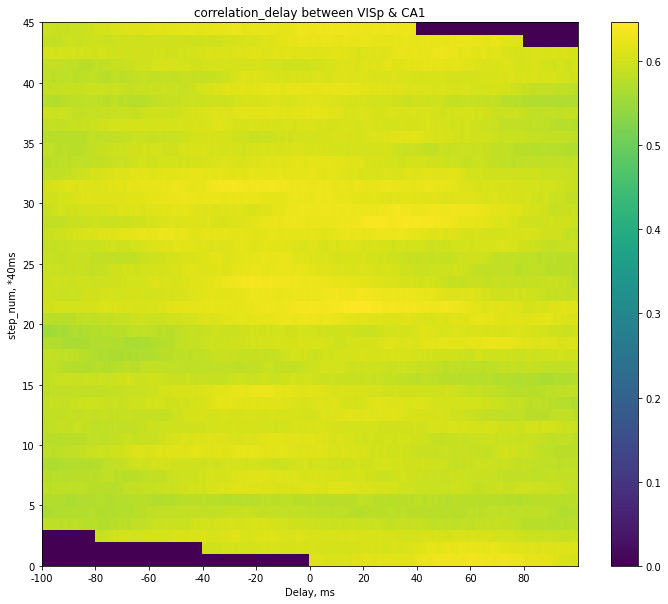

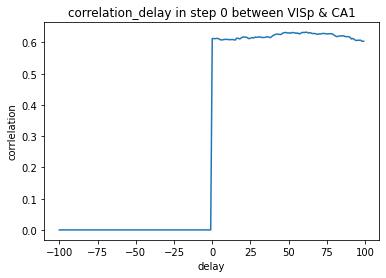

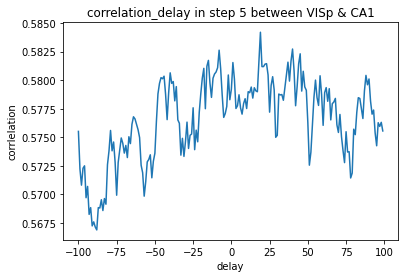

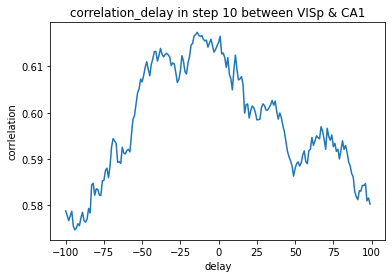

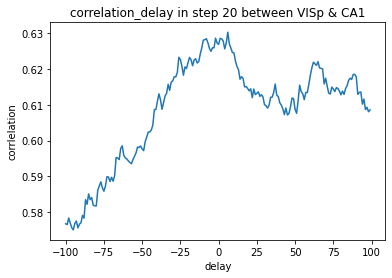

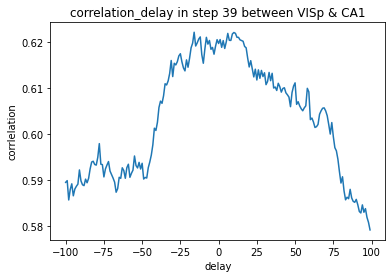

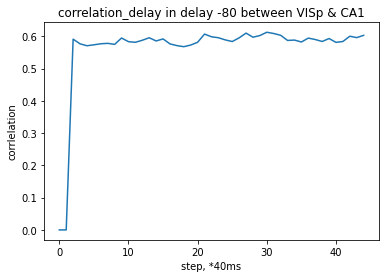

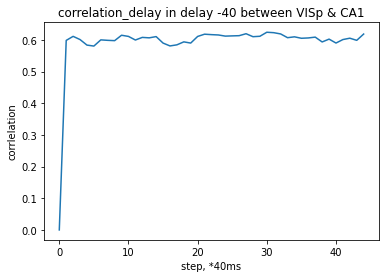

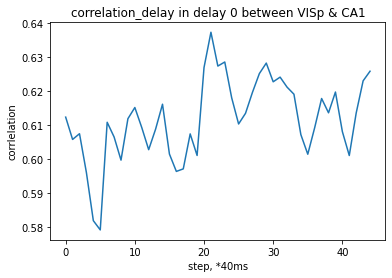

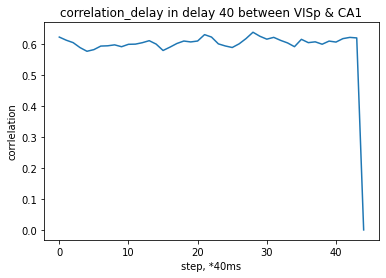

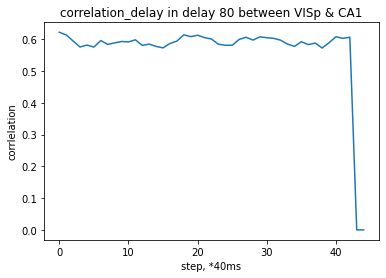

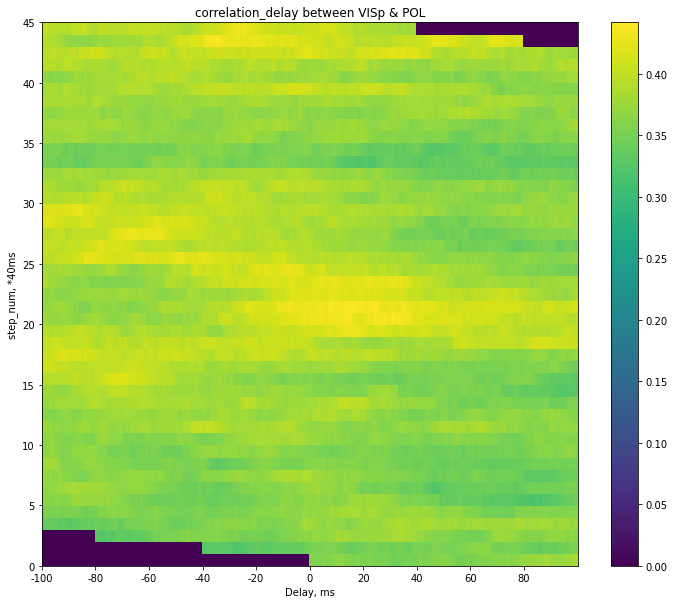

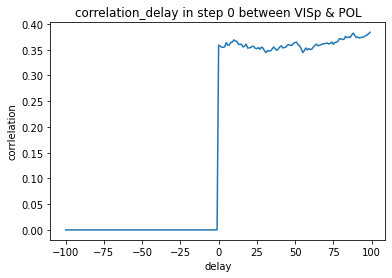

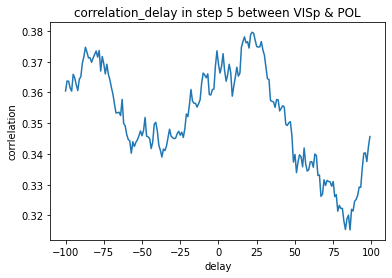

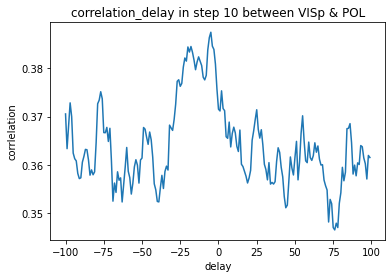

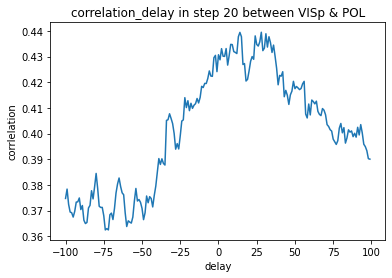

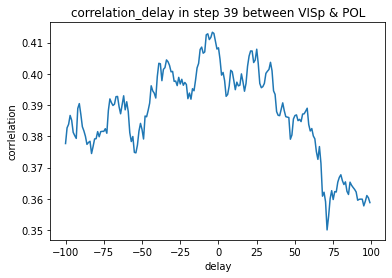

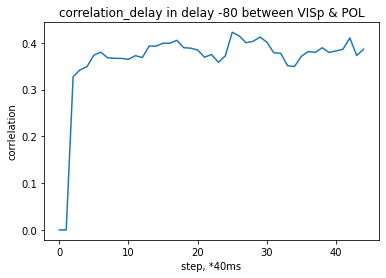

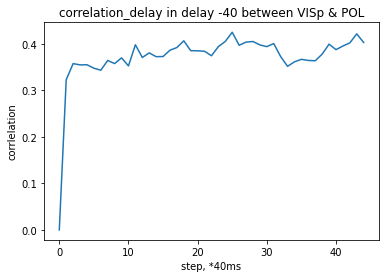

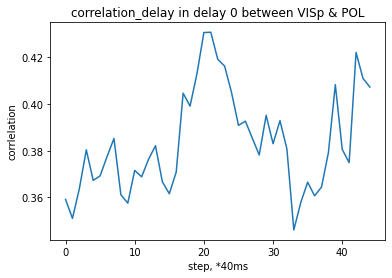

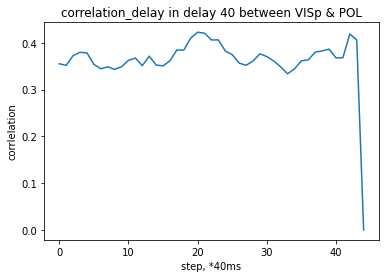

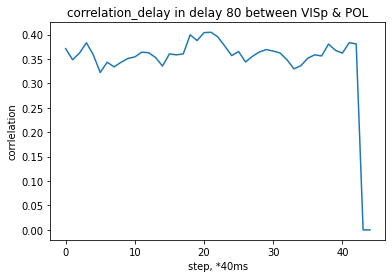

In [ ]:
# plot several representive areas
area_1 = 'VISp'
areas_sorted_selected = ['VISmma', 'LGd', 'CA1', 'POL']
for i in range(len(areas_sorted_selected)):
    area_2 = areas_sorted_selected[i]
    corr_matrix_delay = cca_delay(area_1, area_2)

In [ ]:
# try longer delay
long_max_delay = 250
area_1 = 'VISmma'
area_2 = 'VISrl'

corr_matrix_delay = cca_delay(area_1, area_2, max_delay=long_max_delay)

In [23]:
def cca_delay_across_areas(area_1, area_2, trial_len=2000, window_len=200, step_len=40, bin_len=50, max_delay=100):

    # correlation by delay when time bin = 1ms, with window 200ms, window slide advanced 40ms

    raster_bin = 1  # bin time, 1ms

    spike_raster_1 = spike_matrix(area=area_1, stim_table=drift_stim_table, bin=raster_bin/1000)
    spike_raster_2 = spike_matrix(area=area_2, stim_table=drift_stim_table, bin=raster_bin/1000)

    step_points = np.arange(0, trial_len-window_len, step_len)

    corr_matrix_delay = np.zeros((len(step_points), 2*max_delay))

    for step_id, step in enumerate(step_points):
        t_1 = step
        window_1 = np.arange(t_1, t_1+window_len)
        spike_counts_1 = spike_counts_bins(spike_raster_1[:, window_1, :], bin_len)
        spike_counts_1 = spike_counts_1.reshape([spike_counts_1.shape[0]*spike_counts_1.shape[1],
                                                spike_counts_1.shape[2]])

        slide_points = range(max(t_1-max_delay, 0), min(t_1+max_delay, trial_len-window_len))

        for slide_id, slide in enumerate(slide_points):
            t_2 = slide
            window_2 = np.arange(t_2, t_2+window_len)
            spike_counts_2 = spike_counts_bins(spike_raster_2[:, window_2, :], bin_len)
            spike_counts_2 = spike_counts_2.reshape([spike_counts_2.shape[0]*spike_counts_2.shape[1],
                                                spike_counts_2.shape[2]])

            corr, w, z = corr_area_pairs(spike_counts_1, spike_counts_2)
            corr_matrix_delay[step_id, t_2-t_1+max_delay] = corr[0]
    
    # mask no correlation value
    corr_matrix_delay = np.ma.masked_where(corr_matrix_delay == 0, corr_matrix_delay)
    
    return corr_matrix_delay

In [24]:
# areas_sorted = ['VISmma', 'VISam', 'VISl', 'VISal', 'VISrl', 'VISp', 'LP', 'LGd', 'DG', 'ProS', 'CA1', 'CA2', 'CA3', 'SUB', 'APN', 'POL']
areas_sorted = ['VISmma', 'VISam']
print(len(areas_sorted))
print(areas_sorted)

f, axes = plt.subplots(nrows=len(areas_sorted), ncols=len(areas_sorted), sharex=True, sharey=True, figsize=(20, 18))

for i in range(len(areas_sorted)):
    area_1 = areas_sorted[i]
    for j in range(i, len(areas_sorted)):
        area_2 = areas_sorted[j]
        corr_matrix_delay = cca_delay_across_areas(area_1, area_2)

        im = axes[i, j].pcolormesh(corr_matrix_delay)
        axes[i, j].set_title(f'correlation_delay between {area_1} & {area_2}')

axes[i, j].set_xticks(range(0, corr_matrix_delay.shape[1], 20))
axes[i, j].set_xticklabels(range(0, corr_matrix_delay.shape[1], 20)-np.array([max_delay]))
# ax.set_yticks(range(len(areas))+np.array([0.5]))
# ax.set_yticklabels(areas)
axes[i, j].set_xlabel('Delay, ms')
axes[i, j].set_ylabel('step_num, *40ms')

f.suptitle('correlation_delay across areas')
f.colorbar(im)

plt.show



2
['VISmma', 'VISam']


/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations 

In [ ]:

step_list = [5, 10, 20, 39]

for step in step_list:
    plt.figure()
    plt.plot(range(-max_delay, max_delay), corr_matrix_delay[step, :])
    # plt.vlines(np.argmax(corr_matrix_delay[step, :])-max_delay, 0.4, 1, colors = "g", linestyles = "dashed")
    # plt.vlines(0, 0.4, 1, colors = "r", linestyles = "dashed")
    plt.title(f'correlation_delay in step {step} between {area_1} & {area_2}')
    plt.xlabel('delay')
    plt.ylabel('corrlelation')
    plt.show


In [ ]:


delay_list = [-80, -40, 0, 40, 80]

for delay in delay_list:
    plt.figure()
    plt.plot(range(len(step_points)), corr_matrix_delay[:, delay+max_delay])
    plt.title(f'correlation_delay in delay {delay} between {area_1} & {area_2}')
    plt.xlabel('step, *40ms')
    plt.ylabel('corrlelation')
    # plt.ylim(0.6, 0.9)
    plt.show

* how to measure the delay level of information flow
* cca_delay by different parameters, such as bin_len, window_len, step_len, max_delay
* cca_delay across area pairs, find hierarchy of information flow
* cca_delay between different stimuli, such as spontaneous

test CCA_relay with random matrix

* window=1000, a_neurons=300, b_neurons=300 -> corr is large (0.9+), but not spiky (0.02)
* window=300, a_neurons=300, b_neurons=300 -> corr is almost 1, not spiky
* window=30, a_neurons=300, b_neurons=300 -> corr is almost 1, not spiky

* window=1000, a_neurons=1000, b_neurons=300 -> corr is almost 1, not spiky
* window=1000, a_neurons=300, b_neurons=300 -> corr is large(0.9+), but not spiky (0.02)
* window=1000, a_neurons=50, b_neurons=300 -> corr is large(0.7+), a little spiky (0.05)

* window=1000, a_neurons=50, b_neurons=100 -> corr is large(0.5+), a little spiky (0.05)
* window=1000, a_neurons=50, b_neurons=50 -> corr is large(~0.4), a little spiky (0.07)

* window=500, a_neurons=50, b_neurons=50 -> corr is almost (~0.6), a little spiky (0.08)
* window=100, a_neurons=50, b_neurons=50 -> corr is almost 1, not spiky
* window=30, a_neurons=50, b_neurons=50 -> corr is almost 1, not spiky
* window=3, a_neurons=50, b_neurons=50 -> corr is almost 1, not spiky

* window=1000, a_neurons=300, b_neurons=1000 -> corr is almost 1, not spiky
* window=1000, a_neurons=300, b_neurons=300 -> corr is large(0.9+), but not spiky (0.02)
* window=1000, a_neurons=300, b_neurons=50 -> corr is large(0.7+), a little spiky (0.05)

* the bigger of the window, the smaller of the corr
* the smaller of absolute value neurons, the smaller of the corr

* window=200, a_neurons=100, b_neurons=20 -> is large (0.8+), but not spiky (0.05)
* window=1000, a_neurons=100, b_neurons=20 -> is large (0.4+), but not spiky (0.07)
* window=200, a_neurons=30, b_neurons=20 -> is large (0.6+), but not spiky (0.08)
* window=200, a_neurons=300, b_neurons=200 -> is almost 1, not spiky

* bin=0.001, all 0 rows to much, alomost 1/3-1/2
  * deletle all 0 rows when bin=0.001
  * change bin larger

In [ ]:
# small simulation to test the influence factor of cca
window =200
delay = 200
a = np.random.randint(0, 20, (window, 100))
b = np.random.randint(0, 20, (window+delay, 20))

corr_array = np.empty(delay)

win_1 = a
for i in range(delay):
    print(f'slide{i}')
    win_2 = b[i:i+window, :]
    print(win_2.shape)
    corr, w, z = corr_area_pairs(win_1, win_2)
    print(corr[0])
    corr_array[i] = corr[0]

plt.figure()
plt.plot(range(delay), corr_array)
plt.title(f'correlation_delay')
plt.xlabel('delay')
plt.ylabel('corrlelation')
plt.ylim(0.75, 1)
plt.show

In [ ]:
# #  failed try to plot cca_delay

# # correlation by delay when time bin = 1ms, with window 100ms, window slide advanced 40ms

# stim_time = 2 # stimulus time 2s
# bin_time = 0.001  # bin time 1ms
# trial = 0

# stim_table_trial = drift_stim_table[(drift_stim_table['temporal_frequency'] == 1.0) 
#                     & (drift_stim_table['orientation'] == 90.0)]

# response_matrix = spike_matrix(area='CA1', stim_table=stim_table_trial, bin=bin_time)
# res_mat_1 = response_matrix[trial, :, :]
# print(res_mat_1.shape)
# response_matrix = spike_matrix(area='CA3', stim_table=stim_table_trial, bin=bin_time)
# res_mat_2 = response_matrix[trial, :, :]
# print(res_mat_2.shape)

# window = 0.2      # 200ms, window time when calulate corr
# step_time = 0.04         # 40ms, advanced time step of window
# step_num = int((stim_time - 2*window) / step_time)
# slide_num = int(window / bin_time)

# window_start_time = int(slide_num / 2)    # 100ms, start time of 1st window, area1
# window_time_period = np.arange(slide_num)    # [0, 200ms], window time, area2
# delay = window_time_period - window_start_time

# corr_matrix_delay = np.empty((step_num, slide_num))

# for step in np.arange(step_num):
#     window_start_time = window_start_time + int(step_time / bin_time)
#     window_time_period = window_time_period + int(step_time / bin_time)
#     for i_t in np.arange(len(window_time_period)):
#         corr, w, z = corr_area_pairs(res_mat_1[window_start_time:window_start_time+slide_num, :], 
#                                     res_mat_2[window_time_period[i_t]:window_time_period[i_t]+slide_num, :])
#         corr_matrix_delay[step, i_t] = corr[0]

# print(corr_matrix_delay.shape)

# f, ax = plt.subplots(figsize=(12, 10))
# im = ax.pcolormesh(corr_matrix_delay)

# ax.set_xticks(range(0, len(delay), 20))
# ax.set_xticklabels(range(0, len(delay), 20)-np.array([int(slide_num / 2)]))
# # ax.set_yticks(range(len(areas))+np.array([0.5]))
# # ax.set_yticklabels(areas)
# ax.set_xlabel('Delay, ms')
# ax.set_ylabel('step_num, *40ms')
# ax.set_title(f'correlation_delay in a trial, tem_freq=1.0, ori=90.0')

# f.colorbar(im)

# plt.show

# step_list = [0, 5, 10, 20, 39]

# for step in step_list:
#     plt.figure()
#     plt.plot(delay, corr_matrix_delay[step, :])
#     plt.title(f'correlation_delay in step {step}')
#     plt.xlabel('delay')
#     plt.ylabel('corrlelation')
#     plt.show